In [1]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stat

In [2]:
class LRegression:
    def __init__(self, x, y, color, title, filename, xlabel, ylabel):
        self.x = x
        self.y = y
        self.x_mean = stat.mean(x)
        self.y_mean = stat.mean(y)

        self.color = color
        self.title = title
        self.filename = filename
        self.xlabel = xlabel
        self.ylabel = ylabel
    
    def get(self, test_point):
        #definicao do coeficiente angular (a):
        a_def = 0
        for i in range(len(self.x)):
            a_def += ((self.x[i]-self.x_mean) * (self.y[i]-self.y_mean))
        a_div = 0
        for i in range(len(self.x)):
            a_div += pow((self.x[i] - self.x_mean), 2)
        a = (a_def/a_div)
        b = self.y_mean - (self.x_mean * a) #definicao do coeficiente linear (b)
        
        #incerteza de Y
        incY = 0
        for i in range(len(self.x)):
            incY += pow((self.y[i] - (a * self.x[i] + b)), 2)
        
        incY *= (1/(len(self.x)-2))
        incY = pow(incY, 0.5)
    	
        #incerteza de a:
        incA = 0
        incA = pow(a_div, -1)
        incA = pow(incA, 0.5)
        incA *= incY
        
        #incerteza de b:
        incB = 0
        for i in range(len(self.x)):
            incB += (pow(self.x[i], 2))

        incB*= (1/len(self.x))
        incB = incB/a_div
        incB = pow(incB, 0.5)
        incB*= incY

        y=[]
        for i in range(len(self.x)):
            y.append(a*self.x[i]+b)
       
        
        plt.plot(self.x, self.y, 'k^', label='Dados coletados')
        plt.plot(self.x, y, self.color, label=f'Regressão linear (y = {a :.6f}x + {b :.6f})')
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.legend()
        plt.grid(True)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.savefig(self.filename, dpi=100, edgecolor="#04253a")
        plt.show() #plot do grafico

        return_test = (test_point - b)/a

        return a, b, incA, incB, incY, return_test

In [3]:
class OHAModel(nn.Module):
    def __init__(self):
        super(OHAModel, self).__init__()
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 1)) # 1 InputL, 32 HiddenL, 1 OutputL

    def forward(self, x):
        out = self.linear(x)
        return out

modelVb = OHAModel()
print(modelVb)

OHAModel(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [4]:
class Data():
    def __init__(self, filename):
        data = pd.read_csv(filename)

        d_F = data.drop(columns=['VsppB', 'VsppA'])
        d_Vb  = data.drop(columns=['f(Hz)','VsppA'])
        d_Va = data.drop(columns=['f(Hz)','VsppB'])

        f = d_F.iloc[:, :].values
        Vb =  d_Vb.iloc[:, :].values
        Va =  d_Va.iloc[:, :].values

        self.f = np.array(f, dtype=float).squeeze()
        self.Vb = np.array(Vb, dtype=float).squeeze()
        self.Va = np.array(Va, dtype=float).squeeze()
        self.ft = torch.tensor(f, dtype=torch.float)
        self.Vbt = torch.tensor(Vb, dtype=torch.float)
        self.Vat = torch.tensor(Va, dtype=torch.float)

    def __len__(self):
        return len(self.f)

data = Data("unidade3-fis4-pandas.csv")
print(f"Data size: [{data.__len__()}]")

V_corte = (10.2)/np.sqrt(2)
print(V_corte)

Data size: [8]
7.212489168102784


## Filtro passa-baixa

In [5]:
plt.plot(data.f, data.Vb, 'r-')
plt.plot(data.f, data.Vb, 'k^')
plt.ylabel('Vsef [V]')
plt.xlabel('f[Hz]')
plt.title('Filtro passa-baixa')

plt.show()

: 

: 

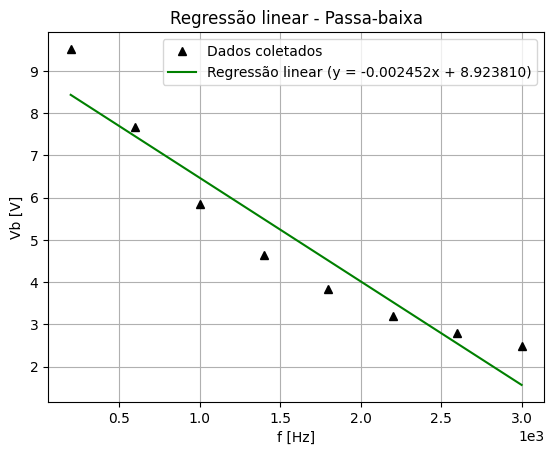

a = -0.0025, b = 8.92, σa = 0.0003, σb = 0.57, σy = 0.8
Frequência de corte:697.820


In [ ]:
baixa_reg = LRegression(data.f, data.Vb, 'g-', 'Regressão linear - Passa-baixa', 'reg_passa-baixa.jpg', 'f [Hz]', 'Vb [V]')
a, b, incA, incB, incY, f_corte = baixa_reg.get(V_corte)
print(f'a = {a :.4f}, b = {b :.2f}, σa = {incA :.4f}, σb = {incB :.2f}, σy = {incY :.1f}')

print(f"Frequência de corte:{f_corte :.3f}")


In [ ]:
optimiser = torch.optim.Adam(modelVb.parameters())
loss_func = nn.MSELoss()

epochs = 20000
x_train = data.ft
y_train = data.Vbt
for epoch in range(epochs):
    optimiser.zero_grad()
    epoch+=1
    inputs = x_train
    desired_outputs = y_train

    out = modelVb(inputs)
    
    loss = loss_func(out, desired_outputs)
    loss.backward()

    optimiser.step()
    #print(f'Epoch {epoch}, loss {loss.item()}', flush=True)

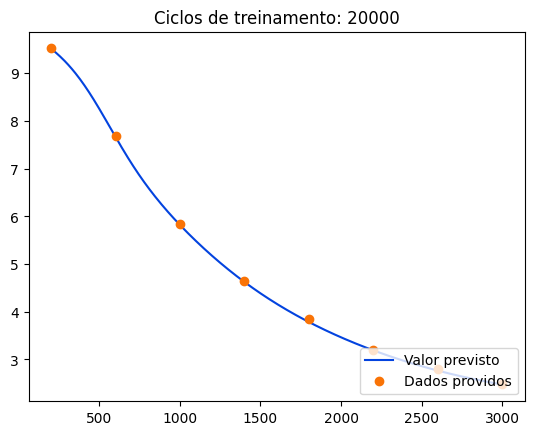

[6.984257]


In [ ]:

vf = torch.linspace(200, 3000, 500).view(-1,1)
fc = torch.tensor([723.43], dtype=torch.float)

predicted = modelVb(vf)
Vc = modelVb(fc)

x = data.ft.detach().numpy()
y = data.Vbt.detach().numpy()

plt.plot(vf, predicted.detach().numpy(), color='xkcd:blue', linestyle='solid', label = 'Valor previsto')
plt.plot(x, y, color='xkcd:orange', marker='o', linestyle='none', label = 'Dados providos')
plt.title(f'Ciclos de treinamento: {epochs}')
plt.legend(loc=4) # 4 = 'lower right'
plt.savefig('grafico-oha.jpg')
plt.show()

print(predicted.detach().numpy())

## Filtro passa-alta

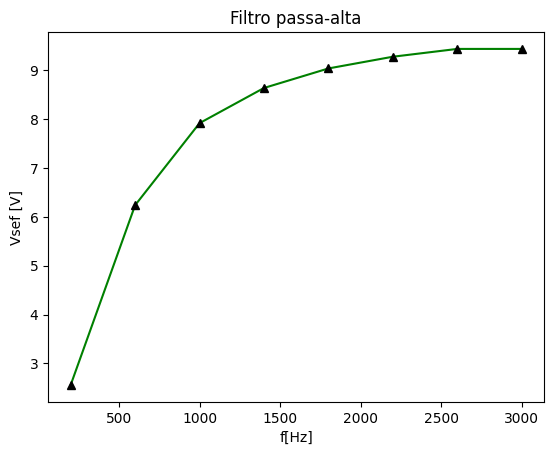

In [ ]:
plt.plot(data.f, data.Va, 'g-')
plt.plot(data.f, data.Va, 'k^')
plt.ylabel('Vsef [V]')
plt.xlabel('f[Hz]')
plt.title('Filtro passa-alta')

plt.show()

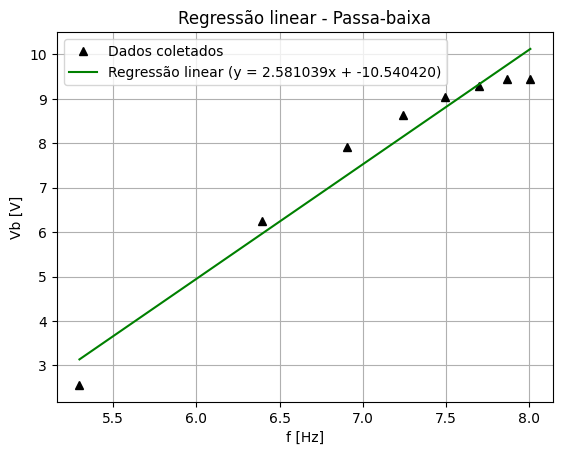

a = 2.5810, b = -10.54, σa = 0.2200, σb = 1.58, σy = 0.5
Frequência de corte:970.880


In [ ]:
baixa_reg = LRegression(np.log(data.f), data.Va, 'g-', 'Regressão linear - Passa-baixa', 'reg_passa-baixa.jpg', 'f [Hz]', 'Vb [V]')
a, b, incA, incB, incY, f_corte = baixa_reg.get(V_corte)
print(f'a = {a :.4f}, b = {b :.2f}, σa = {incA :.4f}, σb = {incB :.2f}, σy = {incY :.1f}')

f_corte = np.exp(f_corte)
print(f"Frequência de corte:{f_corte :.3f}")